In [1]:
import os
import math
import pandas as pd
import bnlearn as bn
import seaborn as sns

In [2]:
df_train = pd.read_csv('data/processed_train.csv')
df_train = df_train.drop(columns=['Date'], axis=1)
df_train.head(5)

,subjectivity,polarity,sentiment,djia_close1,djia_volume,qqq_close,axjo_close,clf_close,djia_close2
0,subjective,negative,negative,up,down,up,up,down,down
1,subjective,positive,negative,down,down,up,up,down,down
2,objective,negative,negative,down,up,down,down,up,up
3,subjective,positive,negative,up,down,up,up,down,up
4,subjective,positive,negative,up,up,down,up,down,down


In [3]:
df_train = df_train.drop(columns=['sentiment','subjectivity','djia_volume'], axis=1)
df_train.head()

,polarity,djia_close1,qqq_close,axjo_close,clf_close,djia_close2
0,negative,up,up,up,down,down
1,positive,down,up,up,down,down
2,negative,down,down,down,up,up
3,positive,up,up,up,down,up
4,positive,up,down,up,down,down


In [4]:
df_train.shape

(1804, 6)

In [5]:
for k in df_train.keys():
    print('{0}: {1}'.format(k, len(df_train[k].unique())))

polarity: 2
djia_close1: 2
qqq_close: 2
axjo_close: 2
clf_close: 2
djia_close2: 2


In [6]:
edges = [('djia_close1', 'djia_close2'),
         ('qqq_close', 'djia_close2'),
         ('axjo_close', 'djia_close2'),
         ('clf_close', 'axjo_close'),
        ('polarity', 'djia_close1')]

# Create the DAG
DAG = bn.make_DAG(edges)
#DAG = bn.structure_learning.fit(df_train, methodtype='hc', scoretype='k2')

[bnlearn] >Bayesian DAG created.


[bnlearn]> Set node properties.
[bnlearn] >Plot based on BayesianModel


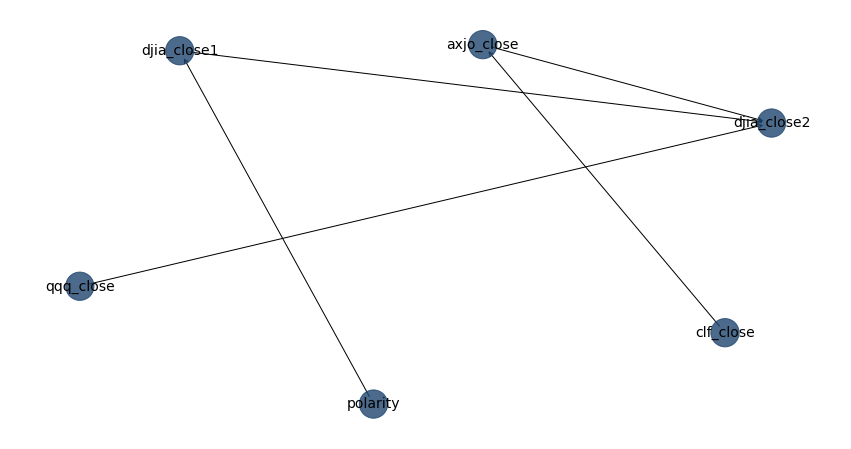

In [7]:
G = bn.plot(DAG)

In [8]:
model = bn.parameter_learning.fit(DAG, df_train, verbose=3)

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of djia_close1:
+-------------------+---------------------+--------------------+
| polarity          | polarity(negative)  | polarity(positive) |
+-------------------+---------------------+--------------------+
| djia_close1(down) | 0.48942042318307266 | 0.4670937682003494 |
+-------------------+---------------------+--------------------+
| djia_close1(up)   | 0.5105795768169273  | 0.5329062317996506 |
+-------------------+---------------------+--------------------+
[bnlearn] >CPD of djia_close2:
+-------------------+-----+--------------------+
| axjo_close        | ... | axjo_close(up)     |
+-------------------+-----+--------------------+
| djia_close1       | ... | djia_close1(up)    |
+-------------------+-----+--------------------+
| qqq_close         | ... | qqq_close(up)      |
+-------------------+-----+--------------------+
| djia_close2(down) | ... | 0.4846153846153846 |
+-------------------+----

In [9]:
df_test = pd.read_csv('data/processed_test.csv')
df_test = df_test.drop(columns=['Date','sentiment','subjectivity','djia_volume'], axis=1)
df_test.head()

,polarity,djia_close1,qqq_close,axjo_close,clf_close,djia_close2
0,positive,up,down,down,down,down
1,positive,down,down,down,down,down
2,negative,down,down,down,down,down
3,positive,down,down,down,down,up
4,positive,up,up,down,down,up


In [10]:
df_test.shape

(120, 6)

In [11]:
Pout = bn.predict(model, df_test, variables=['djia_close2'])

[bnlearn]> Remaining columns for inference: 5


100%|██████████| 28/28 [00:00<00:00, 67.16it/s]


In [12]:
for index in range(Pout.shape[0]):
    if (Pout['djia_close2'][index] == 1):
        Pout.loc[index, 'djia_close2_pred'] = 'up'
    else:
        Pout.loc[index, 'djia_close2_pred'] = 'down'

In [13]:
Pout = Pout.drop(columns=['djia_close2'])
Pout

,p,djia_close2_pred
0,0.518779,down
1,0.564718,up
2,0.564718,up
3,0.564718,up
4,0.509615,up
...,...,...
115,0.564718,up
116,0.530048,up
117,0.509615,up
118,0.515385,up


In [14]:
Pout['djia_close2_pred'].value_counts()

up      106
down     14
Name: djia_close2_pred, dtype: int64

In [15]:
df_test['djia_close2'].value_counts()

up      71
down    49
Name: djia_close2, dtype: int64

In [16]:
df_test2 = pd.read_csv('data/processed_test.csv')

In [17]:
df_combined = pd.concat([df_test2, Pout], axis=1)
df_combined.head(5)

,Date,subjectivity,polarity,sentiment,djia_close1,djia_volume,qqq_close,axjo_close,clf_close,djia_close2,p,djia_close2_pred
0,2016-01-04,subjective,positive,negative,up,down,down,down,down,down,0.518779,down
1,2016-01-05,subjective,positive,negative,down,up,down,down,down,down,0.564718,up
2,2016-01-06,subjective,negative,negative,down,up,down,down,down,down,0.564718,up
3,2016-01-07,objective,positive,negative,down,down,down,down,down,up,0.564718,up
4,2016-01-08,subjective,positive,negative,up,down,up,down,down,up,0.509615,up


Text(0.5, 1.0, 'Actual')

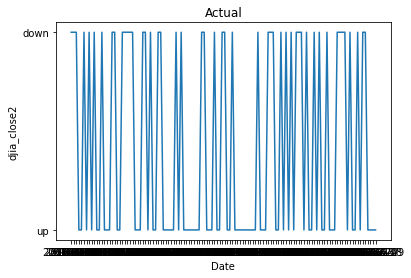

In [18]:
sns.lineplot(data=df_combined, x="Date", y="djia_close2").set_title("Actual")

Text(0.5, 1.0, 'Predicted')

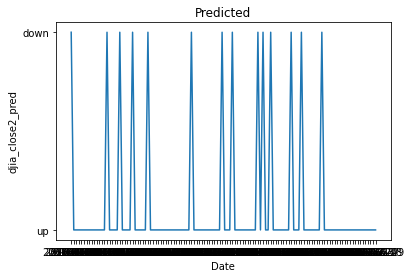

In [19]:
sns.lineplot(data=df_combined, x="Date", y="djia_close2_pred").set_title("Predicted")

In [20]:
pred = list(Pout['djia_close2_pred'])
actual = list(df_test['djia_close2'])

In [21]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(actual, pred)
FN = confusion[1][0]
TN = confusion[0][0]
TP = confusion[1][1]
FP = confusion[0][1]

TP, TN, FP, FN

(65, 8, 41, 6)

In [22]:
recall = (TP)/(TP+FN)
print(recall*100)

91.54929577464789


In [23]:
precision = TP/(TP+FP)
print(precision)

0.6132075471698113


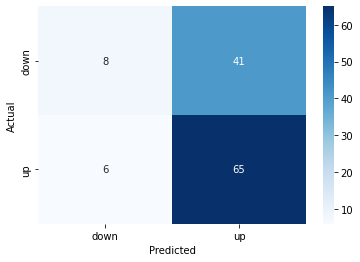

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion , annot=True , xticklabels=['down', 'up'] , yticklabels=['down', 'up'], cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [25]:
from sklearn.metrics import accuracy_score
print(accuracy_score(actual,pred)*100)

60.83333333333333


In [26]:
from sklearn.metrics import classification_report
print(classification_report(actual,pred))

              precision    recall  f1-score   support

        down       0.57      0.16      0.25        49
          up       0.61      0.92      0.73        71

    accuracy                           0.61       120
   macro avg       0.59      0.54      0.49       120
weighted avg       0.60      0.61      0.54       120

